In [ ]:
!pip install pennylane numpy torch matplotlib

In [ ]:
# Pennylane modules
import pennylane as qml
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch import nn
import pandas as pd

from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Hyperparams

In [ ]:
step = 1e-2                 # Learning rate
batch_size = 1              # Number of samples for each training step
num_epochs = 10              # Number of training epochs
rng_seed = 42               # Seed for random number generator
n_qubits = 4 # Number of qubits
q_depth = 6 # Depth of the quantum circuit (number of variational layers)
q_delta = 0.01 # Initial spread of random quantum weights
num_labels = 7

torch.manual_seed(rng_seed)

In [ ]:
# passing a string in backend would result in an error
dev = qml.device('lightning.qubit', wires=6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# IEEE-CIS

In [ ]:
train_data_IEEE = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Zenqor/datasets/v2/IEEE-CIS/train_data.csv")
test_data_IEEE = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Zenqor/datasets/v2/IEEE-CIS/test_data.csv")

In [ ]:
train_data_IEEE.shape, test_data_IEEE.shape

((472432, 51), (118108, 51))

In [ ]:
train_data_IEEE.head()

,TransactionAmt,card1,card2,addr1,C1,C13,P_emaildomain,C12,C14,card5,...,R_emaildomain,card6,D5,DeviceInfo,V317,C7,C9,V315,V283,isFraud
0,-0.322230,-1.003053,-0.181902,0.241728,-0.090257,-0.243633,0.546424,-0.046837,-0.147013,0.644600,...,0.864044,2,-0.242160,0.879809,-0.062221,-0.045973,-0.208847,-0.228634,0.006524,0
1,-0.473167,-1.231887,-0.424641,0.075003,-0.097726,-0.243633,0.546424,-0.035330,-0.147013,0.644600,...,0.864044,1,-0.242160,0.879809,-0.062221,-0.029813,-0.268883,-0.228634,0.006524,0
2,-0.419942,0.546113,-0.603501,1.919395,-0.060379,-0.112188,0.546424,-0.046837,-0.046154,-0.814173,...,0.864044,2,-0.305158,0.879809,-0.062221,-0.045973,-0.088777,0.078151,1.293102,0
3,-0.148520,-0.792592,1.408679,-1.727707,-0.097726,-0.235901,0.004642,-0.046837,-0.147013,0.644600,...,0.001065,1,2.923500,0.879809,-0.062221,-0.045973,-0.268883,-0.228634,-0.636765,0
4,-0.254441,1.260171,0.967916,0.345931,-0.097726,-0.243633,0.546424,-0.046837,-0.147013,-2.370198,...,0.864044,1,-0.242160,0.000483,-0.062221,-0.045973,-0.268883,-0.228634,0.006524,0


In [ ]:
test_data_IEEE.head()

,TransactionAmt,card1,card2,addr1,C1,C13,P_emaildomain,C12,C14,card5,...,R_emaildomain,card6,D5,DeviceInfo,V317,C7,C9,V315,V283,isFraud
0,2.495258,-0.423723,0.757116,0.991989,-0.082787,-0.235901,0.047632,-0.046837,-0.126841,0.595974,...,0.864044,2,-0.399655,0.879809,-0.062221,-0.045973,-0.148812,-0.228634,0.006524,0
1,-0.112507,0.539377,-0.264944,1.919395,-0.090257,-0.197241,0.171089,-0.035330,-0.126841,0.644600,...,0.864044,2,-0.320908,0.879809,-0.062221,-0.045973,-0.208847,-0.228634,-0.636765,0
2,-0.369100,-0.102418,-1.606398,0.241728,-0.097726,-0.228169,0.546424,-0.046837,-0.147013,0.595974,...,0.864044,2,-0.053165,0.879809,-0.062221,-0.045973,-0.208847,0.522057,0.006524,0
3,-0.145872,1.221386,1.165940,0.075003,-0.090257,-0.251365,0.546424,-0.035330,-0.167185,-1.494934,...,0.864044,2,-0.399655,0.879809,-0.036616,-0.029813,-0.268883,-0.228634,0.649813,0
4,-0.114890,1.142182,0.814607,0.075003,-0.030502,0.081113,0.076902,-0.046837,0.014362,0.644600,...,0.864044,2,-0.147663,0.879809,-0.062221,-0.045973,0.091330,-0.228634,-0.636765,0


In [ ]:
def zz_feature_map(x, n):
    for i in range(n):
        qml.Hadamard(wires=i)
        qml.RZ(x[i], wires=i)
    for i in range(n):
        for j in range(i + 1, n):
            qml.CNOT(wires=[i, j])
            qml.RZ((x[i] * x[j]), wires=j)
            qml.CNOT(wires=[i, j])

In [ ]:
# Quantum Support Vector Machine (QSVM) Kernel Function
# def qsvm_kernel(x1, x2):
#     @qml.qnode(dev)
#     def kernel_circuit():
#         qml.AngleEmbedding(x1, wires=range(4))
#         qml.AngleEmbedding(x2, wires=range(4))
#         return qml.probs(wires=range(4))
#     return kernel_circuit()

def qsvm_kernel(x1, x2, n):
    @qml.qnode(dev)
    def feature_map_state(x):
      zz_feature_map(x, n)
      return qml.state()

    psi_1 = feature_map_state(x1)
    psi_2 = feature_map_state(x2)

    return np.abs(np.vdot(psi_1, psi_2))**2

In [ ]:
train_data_IEEE.columns

Index(['TransactionAmt', 'card1', 'card2', 'addr1', 'C1', 'C13',
       'P_emaildomain', 'C12', 'C14', 'card5', 'dist1', 'id_02', 'V200', 'C11',
       'V246', 'D15', 'C2', 'V189', 'C6', 'V201', 'D1', 'V258', 'D4', 'D2',
       'V307', 'V257', 'id_20', 'V45', 'id_31', 'D10', 'V243', 'id_19', 'V308',
       'V310', 'C4', 'D11', 'C8', 'C10', 'card4', 'V127', 'id_01',
       'R_emaildomain', 'card6', 'D5', 'DeviceInfo', 'V317', 'C7', 'C9',
       'V315', 'V283', 'isFraud'],
      dtype='object')

In [ ]:
train_data_IEEE = train_data_IEEE[:1000]

# Correlation matrix

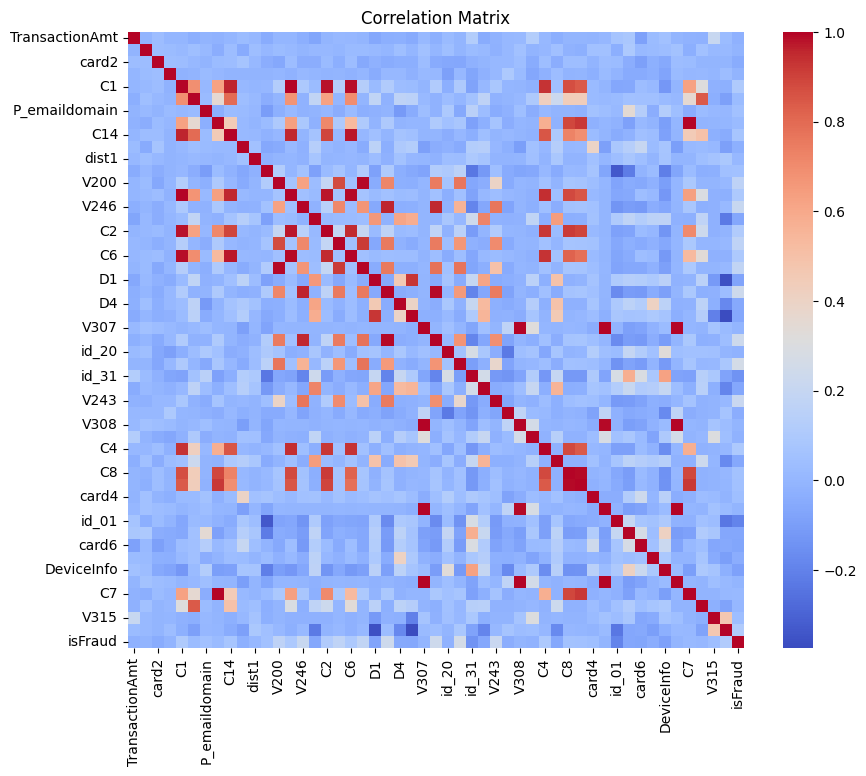

In [ ]:
corr_matrix = train_data_IEEE.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
X_IEEE = train_data_IEEE.drop('isFraud', axis=1)
y_IEEE = train_data_IEEE['isFraud']

In [ ]:
features = ['TransactionAmt', 'card1', 'C1', 'C2']

In [ ]:
X_IEEE = X_IEEE[features]

In [ ]:
X_IEEE_split_train, X_IEEE_split_val, y_IEEE_split_train, y_IEEE_split_val = train_test_split(
    X_IEEE, y_IEEE,
    test_size=0.2,
    random_state=42,
    stratify=y_IEEE,
    shuffle=True
)

In [ ]:
X_IEEE_split_train.shape

(800, 4)

In [ ]:
X_IEEE_split_train = np.array(X_IEEE_split_train)
X_IEEE_split_val = np.array(X_IEEE_split_val)
y_IEEE_split_train = np.array(y_IEEE_split_train)
y_IEEE_split_val = np.array(y_IEEE_split_val)

In [ ]:
print(qsvm_kernel(X_IEEE_split_train[0], X_IEEE_split_train[0]))

0.9999999999999978


## SVC

In [ ]:
def kernel_matrix(A, B):
    return np.array([[qsvm_kernel(a, b, 6) for b in B] for a in A])

In [ ]:
svm = SVC(kernel=kernel_matrix).fit(X_IEEE_split_train, y_IEEE_split_train)

In [ ]:
with dev.tracker:
    predictions = svm.predict(X_IEEE_split_val)

In [ ]:
accuracy_score(predictions, y_IEEE_split_val)

0.96

## after

In [ ]:
K_IEEE_split_train = qml.kernels.kernel_matrix(X_IEEE_split_train, X_IEEE_split_train, kernel=qsvm_kernel)

In [ ]:
K_IEEE_split_val = np.array([[qsvm_kernel(x1, x2) for x2 in X_IEEE_split_train] for x1 in X_IEEE_split_val])

In [ ]:
# Train QSVM with precomputed kernel
clf = SVC(kernel='precomputed')
clf.fit(K_train, y_train)

# Evaluate
y_pred = clf.predict(K_val)

# Classical

In [ ]:
svm_model = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm_model.fit(X_IEEE_split_train, y_IEEE_split_train)

SVC(class_weight='balanced', random_state=42)

In [ ]:
predictions_classical = svm_model.predict(X_IEEE_split_val)

In [ ]:
accuracy_score(predictions_classical, y_IEEE_split_val)

0.735

# From Test dataset

In [ ]:
test_data_IEEE = test_data_IEEE[:100]

In [ ]:
test_data_IEEE

,TransactionAmt,card1,card2,addr1,C1,C13,P_emaildomain,C12,C14,card5,...,R_emaildomain,card6,D5,DeviceInfo,V317,C7,C9,V315,V283,isFraud
0,2.495258,-0.423723,0.757116,0.991989,-0.082787,-0.235901,0.047632,-0.046837,-0.126841,0.595974,...,0.864044,2,-0.399655,0.879809,-0.062221,-0.045973,-0.148812,-0.228634,0.006524,0
1,-0.112507,0.539377,-0.264944,1.919395,-0.090257,-0.197241,0.171089,-0.035330,-0.126841,0.644600,...,0.864044,2,-0.320908,0.879809,-0.062221,-0.045973,-0.208847,-0.228634,-0.636765,0
2,-0.369100,-0.102418,-1.606398,0.241728,-0.097726,-0.228169,0.546424,-0.046837,-0.147013,0.595974,...,0.864044,2,-0.053165,0.879809,-0.062221,-0.045973,-0.208847,0.522057,0.006524,0
3,-0.145872,1.221386,1.165940,0.075003,-0.090257,-0.251365,0.546424,-0.035330,-0.167185,-1.494934,...,0.864044,2,-0.399655,0.879809,-0.036616,-0.029813,-0.268883,-0.228634,0.649813,0
4,-0.114890,1.142182,0.814607,0.075003,-0.030502,0.081113,0.076902,-0.046837,0.014362,0.644600,...,0.864044,2,-0.147663,0.879809,-0.062221,-0.045973,0.091330,-0.228634,-0.636765,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.707099,0.024757,-1.606398,0.345931,-0.082787,0.073381,0.062629,-0.046837,-0.106669,0.644600,...,0.864044,2,-0.163412,0.879809,-0.062221,-0.045973,-0.148812,-0.228634,-0.636765,0
96,0.109926,1.393266,-1.606398,-0.206344,-0.082787,-0.204973,0.047632,-0.046837,-0.106669,0.644600,...,0.864044,1,1.836781,0.879809,-0.062221,-0.045973,-0.208847,-0.228634,0.006524,0
97,2.160549,1.260171,0.967916,1.877714,-0.097726,-0.243633,0.546424,-0.046837,-0.147013,-2.370198,...,0.864044,1,-0.242160,0.879809,-0.062221,-0.045973,-0.268883,-0.228634,0.006524,0
98,-0.284363,-0.993867,-0.597114,-1.758968,0.484888,3.143009,0.076902,-0.035330,1.285188,0.595974,...,0.864044,2,0.734312,0.879809,-0.062221,-0.045973,2.732887,-0.228634,-0.636765,0


In [ ]:
X_IEEE_test = test_data_IEEE.drop('isFraud', axis=1)
y_IEEE_test = test_data_IEEE['isFraud']

In [ ]:
features = ['TransactionAmt', 'card1', 'C1', 'C2']

In [ ]:
X_IEEE_test = X_IEEE_test[features]

In [ ]:
X_IEEE_test = np.array(X_IEEE_test)
y_IEEE_test = np.array(y_IEEE_test)

In [ ]:
accuracy_score(svm_model.predict(X_IEEE_test), y_IEEE_test)

0.75

In [ ]:
accuracy_score(svm.predict(X_IEEE_test), y_IEEE_test)

# SECOM

In [ ]:
# names_SECOM = "/content/drive/MyDrive/Colab_Notebooks/Zenqor/datasets/v2/secom/secom.names"
# data_SECOM = "/content/drive/MyDrive/Colab_Notebooks/Zenqor/datasets/v2/secom/secom.data"
# labels_SECOM = "/content/drive/MyDrive/Colab_Notebooks/Zenqor/datasets/v2/secom/secom_labels.data"

In [ ]:
secom = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Zenqor/datasets/uci-secom/uci-secom.csv")

In [ ]:
secom

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2008-10-16 15:13:00,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,...,203.1720,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720,-1
1563,2008-10-16 20:49:00,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,...,NaN,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720,-1
1564,2008-10-17 05:26:00,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,...,43.5231,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231,-1
1565,2008-10-17 06:01:00,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,...,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941,-1


In [ ]:
secom.isnull().any(axis=0).sum()

np.int64(538)

In [ ]:
secom.shape

(1567, 592)

In [ ]:
secom_ = secom.iloc[:, 1:-1]

In [ ]:
secom_norm = (secom_ - secom_.min()) / (secom_.max() - secom_.min())

In [ ]:
secom_norm.drop('13', axis=1, inplace=True)

In [ ]:
secom_norm.head()

,0,1,2,3,4,6,7,8,9,10,...,580,581,582,583,584,585,586,587,588,589
0,0.469231,0.589292,0.499096,0.379841,0.000609,0.328562,0.965785,0.665019,0.542479,0.358362,...,NaN,NaN,0.709375,0.012325,0.017510,0.011880,NaN,NaN,NaN,NaN
1,0.575003,0.445535,0.666763,0.393982,0.000133,0.428942,0.969673,0.656639,0.412315,0.228669,...,0.181159,0.282386,0.753125,0.034637,0.036965,0.033099,0.221387,0.220339,0.181159,0.282386
2,0.308868,0.583388,0.493903,0.457065,0.000744,0.283455,0.965008,0.542759,0.448168,0.411832,...,0.500000,0.112383,0.562500,0.020612,0.021401,0.020152,0.629073,0.589309,0.500000,0.112383
3,0.400385,0.466998,0.543479,0.244894,0.000574,0.469123,0.946345,0.638590,0.319564,0.359499,...,0.123188,0.100153,0.662500,0.009137,0.007782,0.008734,0.309942,0.152542,0.123188,0.100153
4,0.471367,0.500400,0.678327,0.357067,0.000765,0.387631,0.960342,0.670606,0.392050,0.315131,...,NaN,NaN,0.068750,1.000000,1.000000,1.000000,0.309942,0.152542,0.123188,0.100153


In [ ]:
secom_norm.iloc[0, :]

,0
0,0.469231
1,0.589292
2,0.499096
3,0.379841
4,0.000609
...,...
585,0.011880
586,NaN
587,NaN
588,NaN


In [ ]:
for idx in range(238, 245, 1):
  secom_norm.drop(str(idx), axis=1, inplace=True)

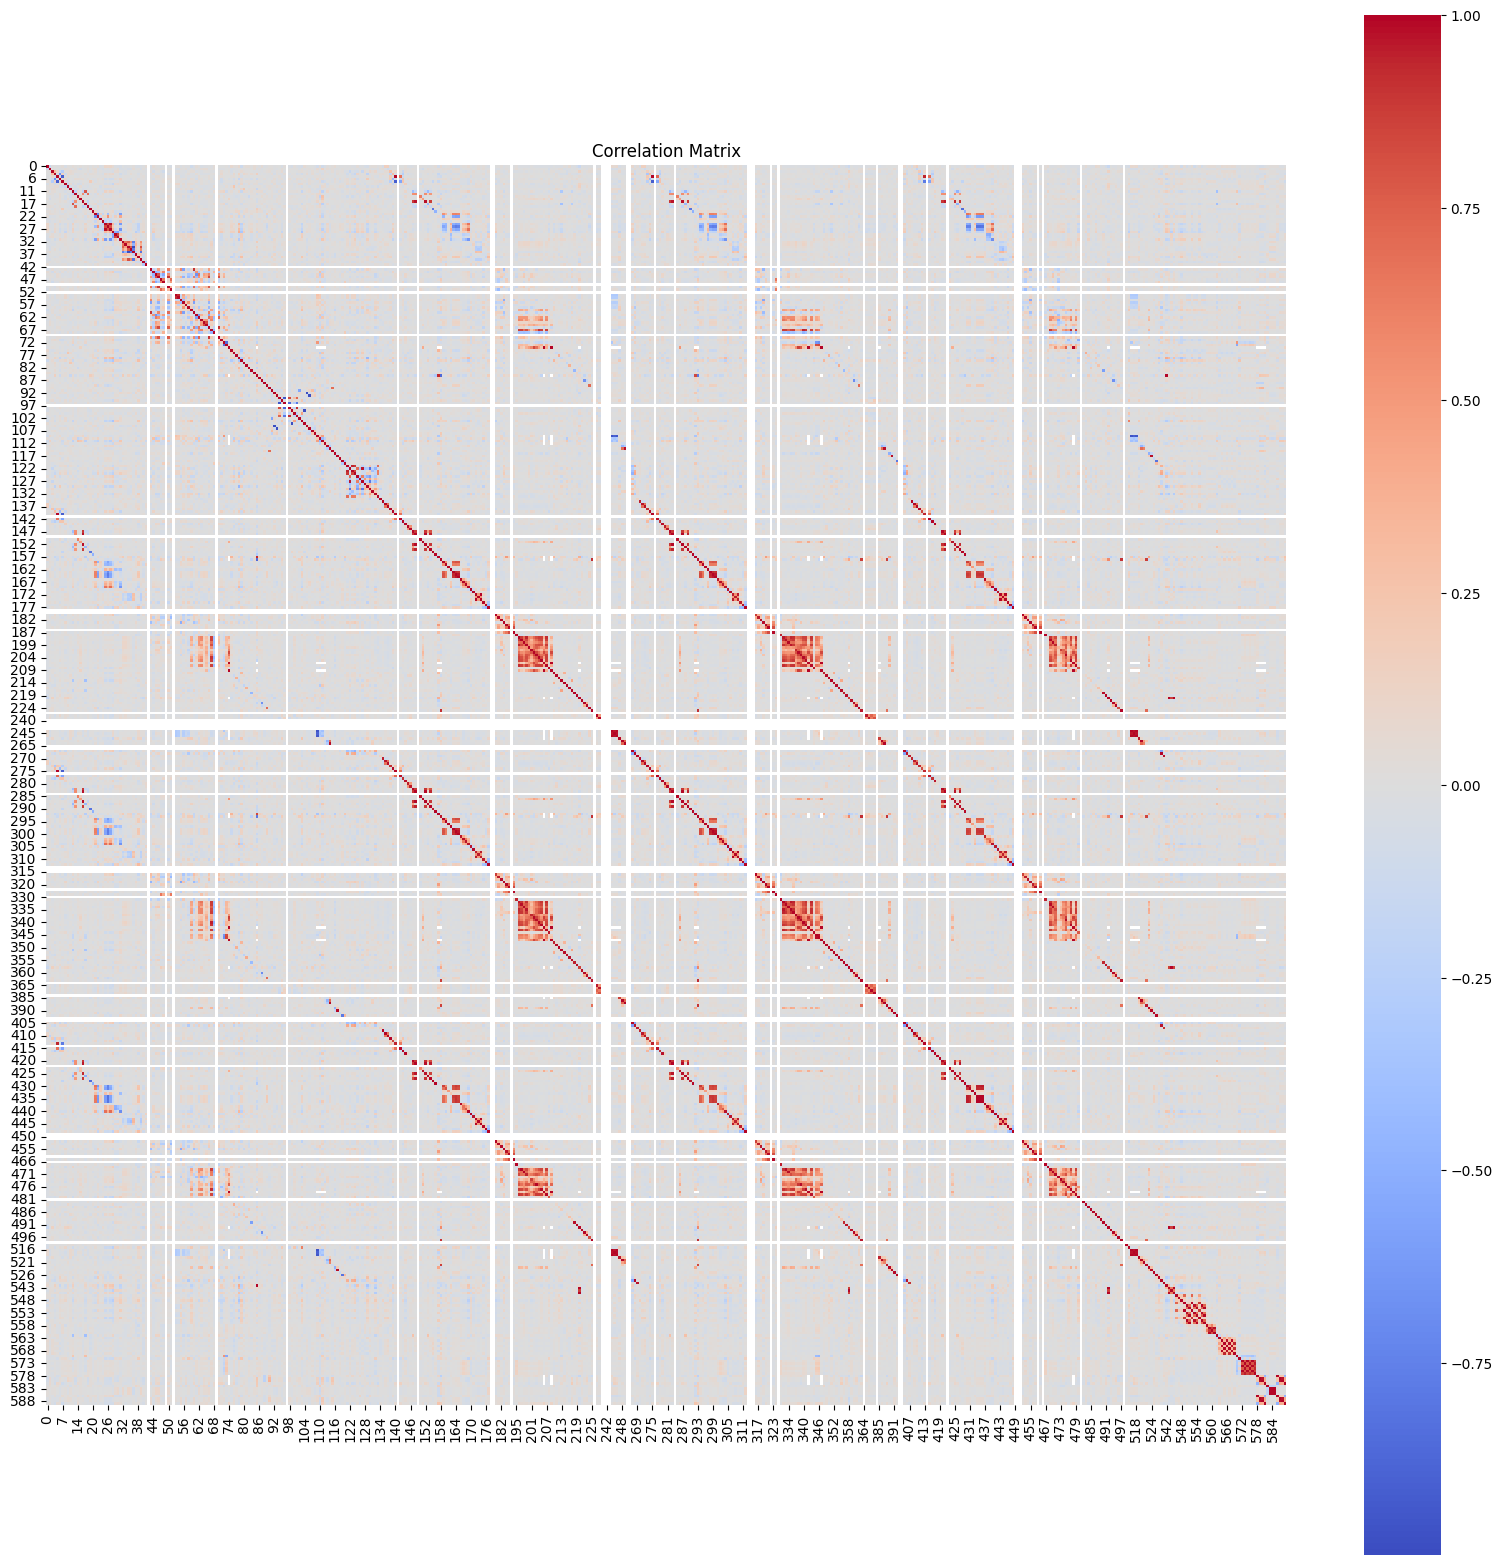

In [ ]:
corr_matrix = secom_norm.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
secom_norm__199_210 = secom_norm[[str(i) for i in range(199, 211, 1)]]

In [ ]:
secom_norm__199_210.shape, secom.shape

((1567, 12), (1567, 592))

In [ ]:
labels = secom.iloc[:, -1]

In [ ]:
labels

,Pass/Fail
0,-1
1,-1
2,1
3,-1
4,-1
...,...
1562,-1
1563,-1
1564,-1
1565,-1


In [ ]:
secom_norm__199_210['Pass/Fail'] = labels

<ipython-input-198-4af9526f44c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secom_norm__199_210['Pass/Fail'] = labels


In [ ]:
secom_norm__199_210

,199,200,201,202,203,204,205,206,207,208,209,210,Pass/Fail
0,0.020266,0.036098,0.042520,0.008235,0.017259,0.000025,0.019953,0.0,0.013866,0.550662,0.0,0.093498,-1
1,0.022925,0.024490,0.029558,0.007459,0.014920,0.000032,0.020960,0.0,0.008840,0.771849,0.0,0.050980,-1
2,0.017917,0.068836,0.040228,0.022544,0.030238,0.000007,0.034618,0.0,0.028040,0.444691,0.0,0.004128,1
3,0.020292,0.052696,0.046787,0.023202,0.033681,0.000030,0.022848,0.0,0.039591,0.596389,0.0,0.191744,-1
4,0.020498,0.084313,0.043626,0.017217,0.052990,0.000035,0.021369,0.0,0.034741,0.520678,0.0,0.123013,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,0.013321,0.048368,0.060618,0.018371,0.016619,0.000008,0.013312,0.0,0.019178,0.360333,0.0,NaN,-1
1563,0.014793,0.108243,0.036908,0.011091,0.049379,0.000010,0.022785,0.0,0.045102,0.877100,0.0,NaN,-1
1564,0.002969,0.082277,0.064412,0.023078,0.043951,0.000002,0.009536,0.0,0.033859,0.324235,0.0,NaN,-1
1565,0.016239,0.031974,0.057852,0.018540,0.017220,0.000005,0.029646,0.0,0.012080,0.318007,0.0,NaN,-1


In [ ]:
secom_norm__199_210.isnull().sum()

,0
199,0
200,0
201,0
202,0
203,0
204,0
205,0
206,0
207,0
208,0


In [ ]:
secom_norm__199_210

,199,200,201,202,203,204,205,206,207,208,209,210,Pass/Fail
0,0.020266,0.036098,0.042520,0.008235,0.017259,0.000025,0.019953,0.0,0.013866,0.550662,0.0,0.093498,-1
1,0.022925,0.024490,0.029558,0.007459,0.014920,0.000032,0.020960,0.0,0.008840,0.771849,0.0,0.050980,-1
2,0.017917,0.068836,0.040228,0.022544,0.030238,0.000007,0.034618,0.0,0.028040,0.444691,0.0,0.004128,1
3,0.020292,0.052696,0.046787,0.023202,0.033681,0.000030,0.022848,0.0,0.039591,0.596389,0.0,0.191744,-1
4,0.020498,0.084313,0.043626,0.017217,0.052990,0.000035,0.021369,0.0,0.034741,0.520678,0.0,0.123013,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,0.003924,0.047859,0.098159,0.032312,0.027973,0.000008,0.021684,0.0,0.030509,0.400006,0.0,0.100103,-1
1539,0.072518,0.058246,0.157275,0.039781,0.051774,0.000010,0.014760,0.0,0.036306,0.436817,0.0,0.064396,-1
1540,0.014483,0.070465,0.058247,0.019380,0.022023,0.000002,0.024736,0.0,0.028745,0.784598,0.0,0.146543,-1
1541,0.012882,0.051474,0.084012,0.031815,0.024867,0.000004,0.022219,0.0,0.020523,0.442547,0.0,0.127348,-1


In [ ]:
X_SECOM = secom_norm__199_210.drop('Pass/Fail', axis=1)
y_SECOM = secom_norm__199_210['Pass/Fail']

In [ ]:
X_SECOM_split_train, X_SECOM_split_test, y_SECOM_split_train, y_SECOM_split_test = train_test_split(
    X_SECOM, y_SECOM,
    test_size=0.2,
    random_state=42,
    stratify=y_SECOM,
    shuffle=True
)

In [ ]:
X_SECOM_split_train = np.array(X_SECOM_split_train)
X_SECOM_split_test = np.array(X_SECOM_split_test)
y_SECOM_split_train = np.array(y_SECOM_split_train)
y_SECOM_split_test = np.array(y_SECOM_split_test)

In [ ]:
print(qsvm_kernel(X_SECOM_split_train[0], X_SECOM_split_train[0], 12))

0.9999999999999976


In [ ]:
X_SECOM_split_train.shape, X_SECOM_split_test.shape

((1228, 12), (308, 12))

In [ ]:
qsvm_SECOM = SVC(kernel=kernel_matrix).fit(X_SECOM_split_train[:200, :], y_SECOM_split_train[:200])

In [ ]:
accuracy_score(qsvm_SECOM.predict(X_SECOM_split_test[:50, :]), y_SECOM_split_test[:50])

0.94

In [ ]:
svm_SECOM = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm_SECOM.fit(X_SECOM_split_train, y_SECOM_split_train)

SVC(class_weight='balanced', random_state=42)

In [ ]:
accuracy_score(svm_SECOM.predict(X_SECOM_split_test[:50, :]), y_SECOM_split_test[:50])

0.84

In [ ]:
accuracy_score(svm_SECOM.predict(X_SECOM_split_train[:50, :]), y_SECOM_split_train[:50])

0.78

In [ ]:
accuracy_score(qsvm_SECOM.predict(X_SECOM_split_train[:50, :]), y_SECOM_split_train[:50])

0.96

# NSL-KDD

In [ ]:
NSLKDD_train = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Zenqor/datasets/v2/NSL-KDD/Train.csv")
NSLKDD_test = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Zenqor/datasets/v2/NSL-KDD/Test.csv")

In [ ]:
NSLKDD_train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,1,20,9,491.0,0.0,0.0,0.0,0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0.0,2,44,9,146.0,0.0,0.0,0.0,0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0.0,1,49,5,0.0,0.0,0.0,0.0,0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0.0,1,24,9,232.0,8153.0,0.0,0.0,1,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0.0,1,24,9,199.0,420.0,0.0,0.0,1,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0.0,1,49,5,0.0,0.0,0.0,0.0,0,0.0,...,25.0,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,1
125969,8.0,2,49,9,105.0,145.0,0.0,0.0,0,0.0,...,244.0,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0
125970,0.0,1,54,9,2231.0,384.0,0.0,0.0,1,0.0,...,30.0,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,0
125971,0.0,1,30,5,0.0,0.0,0.0,0.0,0,0.0,...,8.0,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1


In [ ]:
NSLKDD_test

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,1,49,1,0.0,0.0,0.0,0.0,0,0.0,...,10.0,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,1
1,0.0,1,49,1,0.0,0.0,0.0,0.0,0,0.0,...,1.0,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,1
2,2.0,1,20,9,12983.0,0.0,0.0,0.0,0,0.0,...,86.0,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,0
3,0.0,0,14,9,20.0,0.0,0.0,0.0,0,0.0,...,57.0,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,1
4,1.0,1,60,2,0.0,15.0,0.0,0.0,0,0.0,...,86.0,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0.0,1,54,9,794.0,333.0,0.0,0.0,1,0.0,...,141.0,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,0
22540,0.0,1,24,9,317.0,938.0,0.0,0.0,1,0.0,...,255.0,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,0
22541,0.0,1,24,9,54540.0,8314.0,0.0,2.0,1,1.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,1
22542,0.0,2,12,9,42.0,42.0,0.0,0.0,0,0.0,...,252.0,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,0


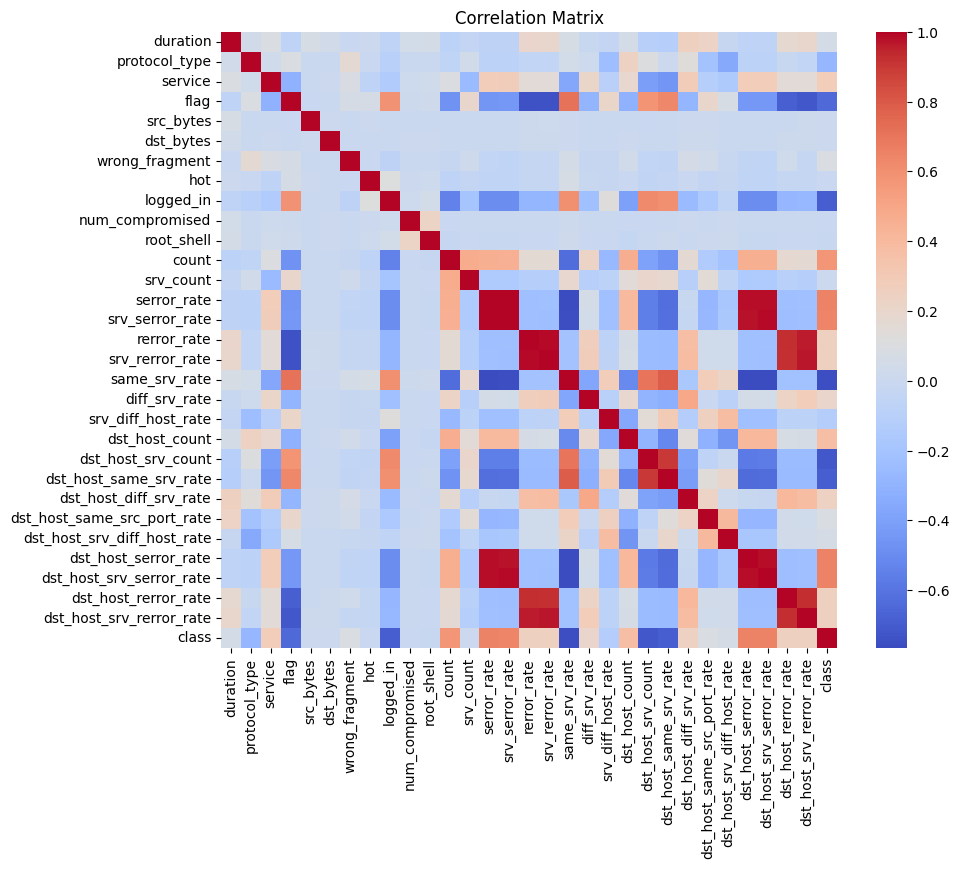

In [ ]:
corr_matrix = NSLKDD_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
NSLKDD_train.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'wrong_fragment', 'hot', 'logged_in', 'num_compromised',
       'root_shell', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
       'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class'],
      dtype='object')

In [ ]:
features_NSLKDD = ['serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate']

In [ ]:
X_NSLKDD = NSLKDD_train.drop('class', axis=1)
X_NSLKDD = X_NSLKDD[features_NSLKDD]

y_NSLKDD = NSLKDD_train['class']

In [ ]:
X_NSLKDD_test = NSLKDD_test.drop('class', axis=1)
X_NSLKDD_test = X_NSLKDD_test[features_NSLKDD]

y_NSLKDD_test = NSLKDD_test['class']

In [ ]:
X_NSLKDD = X_NSLKDD[:100]
y_NSLKDD = y_NSLKDD[:100]

In [ ]:
X_NSLKDD_test = X_NSLKDD_test[:100]
y_NSLKDD_test = y_NSLKDD_test[:100]

In [ ]:
X_NSLKDD_split_train, X_NSLKDD_split_val, y_NSLKDD_split_train, y_NSLKDD_split_val = train_test_split(
    X_NSLKDD, y_NSLKDD,
    test_size=0.2,
    random_state=42,
    stratify=y_NSLKDD,
    shuffle=True
)

In [ ]:
X_NSLKDD_split_train = np.array(X_NSLKDD_split_train)
X_NSLKDD_split_val = np.array(X_NSLKDD_split_val)
y_NSLKDD_split_train = np.array(y_NSLKDD_split_train)
y_NSLKDD_split_val = np.array(y_NSLKDD_split_val)

In [ ]:
X_NSLKDD_test = np.array(X_NSLKDD_test)
y_NSLKDD_test = np.array(y_NSLKDD_test)

In [ ]:
print(qsvm_kernel(X_NSLKDD_split_train[0], X_NSLKDD_split_train[0], 6))

0.9999999999999982


In [ ]:
qsvm_NSLKDD = SVC(kernel=kernel_matrix).fit(X_NSLKDD_split_train, y_NSLKDD_split_train)

In [ ]:
with dev.tracker:
    predictions_qsvm_NSLKDD = qsvm_NSLKDD.predict(X_NSLKDD_split_val)

In [ ]:
accuracy_score(predictions_qsvm_NSLKDD, y_NSLKDD_split_val)

0.85

In [ ]:
svm_model_NSLKDD = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm_model_NSLKDD.fit(X_NSLKDD_split_train, y_NSLKDD_split_train)

SVC(class_weight='balanced', random_state=42)

In [ ]:
predictions_classical_NSLKDD = svm_model_NSLKDD.predict(X_NSLKDD_split_val)

In [ ]:
accuracy_score(predictions_classical_NSLKDD, y_NSLKDD_split_val)

0.85

In [ ]:
with dev.tracker:
    predictions_qsvm_NSLKDD_test = qsvm_NSLKDD.predict(X_NSLKDD_test)

In [ ]:
accuracy_score(predictions_qsvm_NSLKDD_test, y_NSLKDD_test)

0.85

In [ ]:
predictions_classical_NSLKDD_test = svm_model_NSLKDD.predict(X_NSLKDD_test)

In [ ]:
accuracy_score(predictions_classical_NSLKDD_test, y_NSLKDD_test)

0.85